In [1]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
device = "cpu"

Device: cuda:0


In [2]:
import numpy as np
import os
from get_data import get_data
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.tensorflow import balanced_batch_generator
from numpy.random import default_rng
rng = default_rng(seed = 31)
import pickle
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  GridSearchCV
import geopandas as gpd
import shapely
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
import libpysal
from copy import deepcopy
import matplotlib.pyplot as plt

In [3]:
from torch import nn, optim
import scipy.ndimage as ndimage

In [4]:
# X, Y, ID = get_data("../Data/filled/grids/", [2015,2016,2017,2018,2019])

In [5]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [6]:
def load_data(year):
    os.getcwd()
    
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        df1 = pd.read_csv(path + filename)
        print(filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [7]:
# df15 = load_data(2015)
# df16 = load_data(2016)
df17 = load_data(2017)
df18 = load_data(2018)
df19 = load_data(2019)

Nijmegen17.csv_filled_.csv
Nijmegen18.csv_filled_.csv
Nijmegen19.csv_filled_.csv


In [8]:
X_train = df17[df17.columns[:-4]]
Y_train = df17.y
Y1_train = df17["y-1"]
# print(X_train)
# X_train = ss.fit_transform(X_train)

X_val = df18[df18.columns[:-4]]
Y_val = df18.y
Y1_val = df18["y-1"]

wt = libpysal.weights.DistanceBand.from_dataframe(df17, threshold=150, binary = True, silence_warnings = True)
wv =libpysal.weights.DistanceBand.from_dataframe(df18, threshold=150, binary = True, silence_warnings = True)

X_test = df19[df19.columns[:-4]]
Y_test = df19.y
Y1_test = df19["y-1"]

wtest = libpysal.weights.DistanceBand.from_dataframe(df19, threshold=150, binary = True, silence_warnings = True)

In [9]:
neighbors = [wt.neighbors[x] for x in wt.neighbors]
Y1_train = np.array([Y1_train[x].sum() for x in neighbors])
Y1_train[np.where(Y1_train == 0)[0]] = 0.5

neighbors = [wv.neighbors[x] for x in wv.neighbors]
Y1_val = np.array([Y1_val[x].sum() for x in neighbors])
Y1_val[np.where(Y1_val == 0)[0]] = 0.5

neighbors = [wtest.neighbors[x] for x in wtest.neighbors]
Y1_test = np.array([Y1_test[x].sum() for x in neighbors])
Y1_test[np.where(Y1_test == 0)[0]] = 0.5


In [10]:
X_train = ss.fit_transform(X_train)
X_train[:,-1] = Y1_train
X_val = ss.transform(X_val)
X_val[:,-1] = Y1_val
X_test = ss.transform(X_test)
X_test[:,-1] = Y1_test


In [11]:
oversample = SMOTE()
x, y =  oversample.fit_resample(X_train, Y_train)

In [12]:
x[x[:,-1]>0.5][:,-1] =  np.ceil(x[x[:,-1] > 0.5][:,-1]) # 0.5 means no neighbors, otherwise make int


x = torch.tensor(x).float().to(device)
y = torch.tensor(y).float().to(device)
X_val = torch.tensor(X_val).float().to(device)
Y_val = torch.tensor(Y_val).float().to(device)

In [13]:
X_test = torch.tensor(X_test).float().to(device)
Y_test = torch.tensor(Y_test).float().to(device)

In [14]:
rng = default_rng()
def get_batch(X, Y, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs]



In [15]:
 # best auc: 0.675, f1: 0.476, lr: 0.00000051, epochs: 10000
class Model(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [16]:
class Model1(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,100),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(50,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [17]:
 # best auc: 0.675, f1: 0.476, lr: 0.00000051, epochs: 10000
class Model2(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,150),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(150,500),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(500,100),
            nn.ReLU(),
            nn.Linear(100,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [18]:
 # best auc: 0.675, f1: 0.476, lr: 0.00000051, epochs: 10000
class Model3(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [19]:
 # best auc: 0.675, f1: 0.476, lr: 0.00000051, epochs: 10000
class Model4(nn.Module):
    def __init__(self,  drop_rate = 0.2):
        super(Model4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(39,40),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(40,80),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(80,1)
             )

        self.final = nn.Sigmoid()

    def forward(self, x):
        Y_1 = x[:,-1].reshape(-1,1) # take yt-1 of neighbors
        x = x[:,:-1]
        out = self.net(x) # get p
        
        out *= Y_1 # multiply with yt-1

        return out
       

In [20]:
model = Model().to(device)
model1 = Model1().to(device)
model2 = Model2().to(device)
model3 = Model3().to(device)
model4 = Model4().to(device)

models = [model, model1, model2, model3, model4]
# models = [model]

In [21]:
def train(models, X_train, Y_train, Y1_train, X_val, Y_val, Y1_val, num_epochs, lr, batch_per_e = 100 ):

    best_auc, best_f1, best_model, best_epoch, best_lr = 0,0,0,0,0
    
    for i, model in enumerate(models):
        for lr in [0.00000051, 0.0000051]:
#         for lr in [0.0000051]:
            optimizer = optim.Adam(model.parameters(), lr=lr) 
            SigBCEloss = nn.BCEWithLogitsLoss()
            ROC_history = []

            for epoch in range(num_epochs):
                epoch_loss = []
#                 print("epoch: {} of {}".format(epoch, num_epochs))
                for batch in range(batch_per_e):

                    x, y = get_batch(X_train, Y_train, 6)

                    model.train()

                    optimizer.zero_grad()
                    out = model(x).squeeze()


                    loss = SigBCEloss(out, y)
                    loss.backward()
                    optimizer.step()


                    epoch_loss.append(loss.detach().numpy())

                model.eval()

                out = model(X_val)
                ROC = roc_auc_score(Y_val, model.final(out).detach().numpy())
                out = out.squeeze().detach().numpy()

                preds = np.zeros(len(out))
                pos = out.argsort()[-((Y_val == 1).sum()):]
                preds[pos] = 1
                
                f1 = f1_score(Y_val, preds)

                ROC_history.append(ROC)

                if ROC > best_auc:
                    print("model: {}, ROC:{}, f1: {}, lr: {}, epoch = {}".format(i, ROC, f1, lr, epoch))
                    best_auc = ROC
                    best_f1 = f1
                    best_model = deepcopy(model.state_dict())
                    best_epoch = epoch
                    best_lr = lr

                train_loss = []
                          
            print(np.max(ROC_history), np.argmax(ROC_history), lr)
            plt.plot(ROC_history, alpha = 0.5)
            plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r") 
            linear_model=np.polyfit(range(n_epochs), ROC_history, 2)
            linear_model_fn=np.poly1d(linear_model)
            x_s=np.arange(0,n_epochs)
            plt.plot(linear_model_fn(x_s))  
            plt.show()
                          
    result = np.argmax(ROC_history)
    return best_auc, best_f1, best_model, best_epoch

model: 0, ROC:0.6692309127223646, f1: 0.1917808219178082, lr: 5.1e-07, epoch = 0
model: 0, ROC:0.6712861735905975, f1: 0.1917808219178082, lr: 5.1e-07, epoch = 1
model: 0, ROC:0.6728724219300665, f1: 0.1917808219178082, lr: 5.1e-07, epoch = 2
model: 0, ROC:0.6744293569864879, f1: 0.1963470319634703, lr: 5.1e-07, epoch = 3
model: 0, ROC:0.6755139484592538, f1: 0.1963470319634703, lr: 5.1e-07, epoch = 4
model: 0, ROC:0.6772414335261346, f1: 0.20091324200913238, lr: 5.1e-07, epoch = 5
model: 0, ROC:0.6791507941901073, f1: 0.20091324200913238, lr: 5.1e-07, epoch = 6
model: 0, ROC:0.6808389728092651, f1: 0.20091324200913238, lr: 5.1e-07, epoch = 7
model: 0, ROC:0.6819062427965938, f1: 0.20091324200913238, lr: 5.1e-07, epoch = 8
model: 0, ROC:0.683279969833967, f1: 0.20091324200913238, lr: 5.1e-07, epoch = 9
model: 0, ROC:0.6840727608982122, f1: 0.20091324200913238, lr: 5.1e-07, epoch = 10
model: 0, ROC:0.6850587531461811, f1: 0.20091324200913238, lr: 5.1e-07, epoch = 11
model: 0, ROC:0.6862

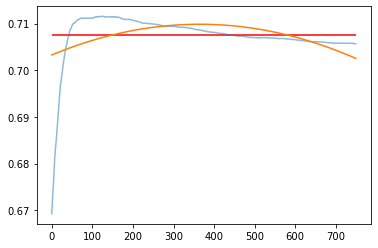

model: 0, ROC:0.7116199186423153, f1: 0.2420091324200913, lr: 5.1e-06, epoch = 550
model: 0, ROC:0.7117078584914585, f1: 0.2420091324200913, lr: 5.1e-06, epoch = 551
model: 0, ROC:0.7117891362308181, f1: 0.2420091324200913, lr: 5.1e-06, epoch = 552
model: 0, ROC:0.7120336356598753, f1: 0.2420091324200913, lr: 5.1e-06, epoch = 553
model: 0, ROC:0.7120616165209663, f1: 0.2420091324200913, lr: 5.1e-06, epoch = 554
model: 0, ROC:0.71207227589662, f1: 0.2420091324200913, lr: 5.1e-06, epoch = 556
model: 0, ROC:0.7121082512894514, f1: 0.2420091324200913, lr: 5.1e-06, epoch = 557
model: 0, ROC:0.7122081829362049, f1: 0.2420091324200913, lr: 5.1e-06, epoch = 558
model: 0, ROC:0.7123734032588377, f1: 0.2374429223744292, lr: 5.1e-06, epoch = 559
model: 0, ROC:0.7125965839365873, f1: 0.2374429223744292, lr: 5.1e-06, epoch = 560
model: 0, ROC:0.7126025798353925, f1: 0.2420091324200913, lr: 5.1e-06, epoch = 568
model: 0, ROC:0.7126811927308387, f1: 0.2374429223744292, lr: 5.1e-06, epoch = 574
model:

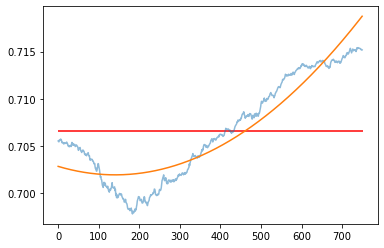

0.6872659101174796 749 5.1e-07


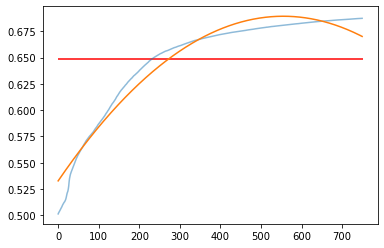

0.6994622344982699 715 5.1e-06


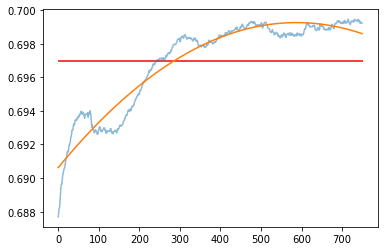

0.7098311421654254 503 5.1e-07


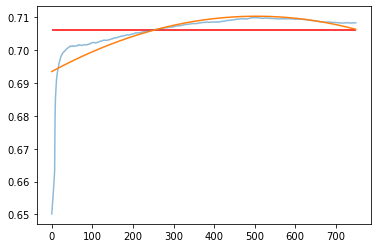

0.7085566805638277 615 5.1e-06


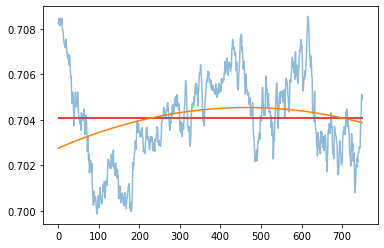

0.639996242570082 749 5.1e-07


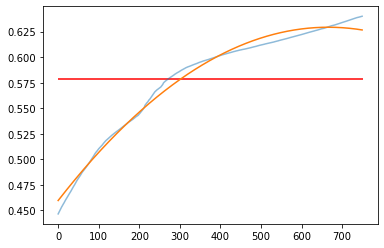

0.7064447917624345 747 5.1e-06


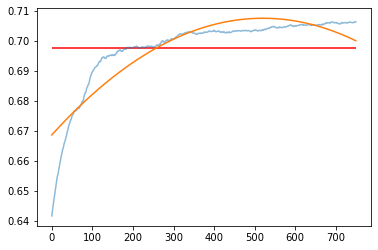

0.6968060513275587 749 5.1e-07


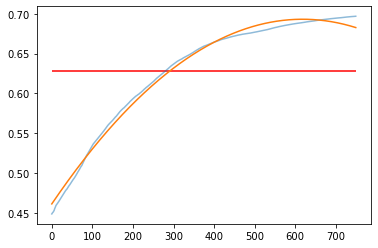

0.7121135809772782 137 5.1e-06


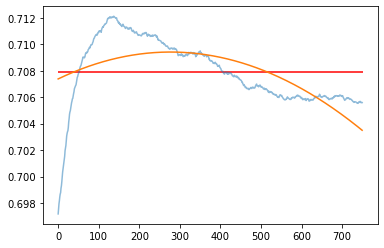

In [22]:
n_epochs = 750
hists = train(models, x, y, Y1_train, X_val, Y_val, Y1_val, n_epochs, 0.0000051)

In [28]:
hists[2]

OrderedDict([('net.0.weight',
              tensor([[ 0.1620,  0.0914,  0.1170,  ...,  0.1329,  0.0127,  0.1875],
                      [ 0.0667, -0.0556,  0.1670,  ...,  0.0713, -0.0376,  0.1521],
                      [-0.0829,  0.0468, -0.1465,  ..., -0.1269,  0.0833,  0.1015],
                      ...,
                      [-0.0707,  0.0131, -0.0058,  ...,  0.0355, -0.1415, -0.0893],
                      [ 0.0035, -0.0554,  0.1544,  ..., -0.0157, -0.1213, -0.1075],
                      [ 0.0066,  0.0761, -0.0559,  ...,  0.0284,  0.1855, -0.2091]])),
             ('net.0.bias',
              tensor([ 0.0056, -0.1418,  0.0991, -0.0408, -0.1691, -0.0429,  0.1209, -0.1023,
                      -0.0562,  0.0696, -0.0186, -0.1279, -0.1580, -0.1482,  0.0465, -0.0374,
                       0.1374, -0.0162,  0.0373, -0.0011, -0.0326, -0.0215, -0.1122,  0.0446,
                       0.0733,  0.0082, -0.0241,  0.0532,  0.1310,  0.0692,  0.0180, -0.0739,
                      -0.0324,  

best model den haag: model 0, lr:5.1e-06

# Testing:

In [23]:
model = Model()
model.load_state_dict(hists[2])
model.eval()

Model(
  (net): Sequential(
    (0): Linear(in_features=39, out_features=100, bias=True)
    (1): Dropout(p=0.3, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=250, bias=True)
    (4): Dropout(p=0.3, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=250, out_features=100, bias=True)
    (7): ReLU()
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
  (final): Sigmoid()
)

In [24]:
out = model(X_test)

ROC = roc_auc_score(Y_test, model.final(out).detach().numpy())
out = out.squeeze().detach().numpy()

preds = np.zeros(len(out))
pos = out.argsort()[-((Y_test == 1).sum()):]
preds[pos] = 1

f1 = f1_score(Y_test, preds)



In [25]:
print(ROC, f1)

0.6623821543701721 0.26433915211970077


In [26]:
with open ("../Results/Nijmegen.csv", "a+") as f:
    f.write("\nMLP,{},{}".format(ROC,f1))

# Neighbor function

In [12]:
def neighbor_part(model, X, idxs, w):
    preds = model(torch.from_numpy(X).float())
    preds = pd.DataFrame(np.array(preds.detach())).set_index(idxs)
    
    neighbors = [w.neighbors[x] for x in idxs]
    transitions = [preds.loc[x].values for x in neighbors]



    n_function = np.zeros((len(preds), w.max_neighbors + 1))
    for i, (t, idx) in enumerate(zip(transitions, idxs)):
        n_function[i, 1:len(t) + 1] = t.squeeze()
        n_function[i, 0] = preds.loc[idx]
        
    return n_function

In [13]:
w15 = libpysal.weights.DistanceBand.from_dataframe(df15, threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16, threshold=150, binary = True, silence_warnings = True)

for mod in models:
    hists = train_model(mod, x_train, y_train, X_val, Y_val, 250)
    n_function = neighbor_part(mod, X_train, df15.index, w15)
        
    oversample = SMOTE()
    x, y = oversample.fit_resample(n_function, Y_train)

    clf_bagger = RandomForestClassifier(max_depth = 12, oob_score = True)
    clf_bagger.fit(x,y)
    
    n_function = neighbor_part(mod, X_val, df16.index, w16)
    preds = clf_bagger.predict(n_function)
    totacc = accuracy_score(Y_val, preds)
    totf1 = f1_score(Y_val, preds)
    totROC = roc_auc_score(Y_val, preds)
    
    
    with open("../results/mlp/" + mod.name + ".csv", "a+") as f:
        f.write("loss;acc;ROC;f1_score\n")
        f.write(str(hists[2]) + ";" + str(hists[0]) + ";" + str(hists[1]) + ";" + str(hists[3]) + "\n")
        f.write("--;" + str(totacc) + ";" + str(totROC) + ";"  + str(totf1))
    
    
    

NameError: name 'models' is not defined

In [246]:
neighbor_part(model, X_train, df15.index, w15)

In [24]:
X_val

array([[-0.20477431, -0.06709367, -0.24659556, ...,  0.46299088,
         0.45272231,  0.69077765],
       [-0.20477431, -0.06709367, -0.24659556, ...,  0.2866995 ,
         0.16036807, -0.03776353],
       [-0.20477431, -0.06709367,  1.24801218, ...,  0.80675908,
         0.81004415,  0.84689361],
       ...,
       [-0.20477431, -0.06709367, -0.24659556, ...,  0.68335511,
         0.79380225,  0.11835244],
       [-0.20477431, -0.06709367, -0.24659556, ...,  1.49870277,
         1.28105931,  0.48262303],
       [-0.20477431, -0.06709367, -0.24659556, ...,  1.30037496,
         1.24857551,  0.11835244]])

In [281]:
hists

([0.7477, 0.7461],
 [0.4551122194513716, 0.45591939546599497],
 [0.1489188086495308, 0.14661806399351965],
 [0.23744001984596252, 0.2417915314435959])

In [257]:
np.sum(preds == 1)

15948

In [165]:
# X_train = torch.from_numpy(X_train).float()
preds = model(X_train)

In [166]:
w15 = libpysal.weights.DistanceBand.from_dataframe(df15, threshold=150, binary = True, silence_warnings = True)


In [167]:
import pandas as pd

preds = pd.DataFrame(np.array(preds.detach())).set_index(df15.index)

In [168]:

# preds = pd.DataFrame(np.array(preds.detach())).set_index(ID_train)
neighbors = [w15.neighbors[x] for x in df15.index]
transitions = [preds.loc[x].values for x in neighbors]



n_function = np.zeros((len(preds), w15.max_neighbors + 1))
for i, (t, idx) in enumerate(zip(transitions, df15.index)):
    n_function[i, 1:len(t) + 1] = t.squeeze()
    n_function[i, 0] = preds.loc[idx]

In [169]:
params = {"max_depth": [12], "oob_score" : [True, False]}
clf_bagger = GridSearchCV(RandomForestClassifier(), params, cv = 5, scoring = "balanced_accuracy",
                               verbose = 3)
clf_bagger = RandomForestClassifier(max_depth = 12, oob_score = True)
oversample = SMOTE()
x, y = oversample.fit_resample(n_function, Y_train)

clf_bagger.fit(x,y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END .......max_depth=6, oob_score=True;, score=0.855 total time=   6.5s
[CV 2/5] END .......max_depth=6, oob_score=True;, score=0.865 total time=   6.4s
[CV 3/5] END .......max_depth=6, oob_score=True;, score=0.863 total time=   6.5s
[CV 4/5] END .......max_depth=6, oob_score=True;, score=0.829 total time=   6.2s
[CV 5/5] END .......max_depth=6, oob_score=True;, score=0.833 total time=   6.2s
[CV 1/5] END ......max_depth=6, oob_score=False;, score=0.855 total time=   5.7s
[CV 2/5] END ......max_depth=6, oob_score=False;, score=0.865 total time=   5.9s
[CV 3/5] END ......max_depth=6, oob_score=False;, score=0.862 total time=   6.7s
[CV 4/5] END ......max_depth=6, oob_score=False;, score=0.829 total time=   6.1s
[CV 5/5] END ......max_depth=6, oob_score=False;, score=0.833 total time=   6.0s
[CV 1/5] END .......max_depth=8, oob_score=True;, score=0.853 total time=   9.3s
[CV 2/5] END .......max_depth=8, oob_score=True;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [6, 8, 10, 12],
                         'oob_score': [True, False]},
             scoring='balanced_accuracy', verbose=3)

In [170]:
clf_bagger.best_params_

{'max_depth': 12, 'oob_score': False}

In [171]:
np.array(preds.detach())

AttributeError: 'DataFrame' object has no attribute 'detach'

In [173]:
# X_val = torch.from_numpy(X_val).float()
preds = model(X_val)

In [174]:
w16 = libpysal.weights.DistanceBand.from_dataframe(df16, threshold=150, binary = True, silence_warnings = True)


In [175]:
preds = pd.DataFrame(np.array(preds.detach())).set_index(df16.index)
neighbors = [w16.neighbors[x] for x in df16.index]
transitions = [preds.loc[x].values for x in neighbors]



n_function = np.zeros((len(preds), w16.max_neighbors + 1))
for i, (t, idx) in enumerate(zip(transitions, df16.index)):
    n_function[i, 1:len(t) + 1] = t.squeeze()
    n_function[i, 0] = preds.loc[idx]

In [176]:
preds = clf_bagger.predict(n_function)

In [177]:
len(neighbors)

57050

In [178]:
clf_bagger.score(n_function, Y_val)

0.5819144337554594

In [179]:
recall_score(Y_val, preds)

0.3210421726650475

In [180]:
precision_score(Y_val, preds)

0.14972711358253527

In [246]:
(Y_val == 1).sum()

4529

# No bagger on the end

In [277]:
preds = pd.DataFrame(np.array(preds.detach())).set_index(ID_val)

In [279]:
preds["y"] = Y_val

In [280]:
preds = preds.sort_values(by=[0], ascending = False)

In [281]:
preds

,0,y
3699708.0,9.999919e-01,0.0
2206980.0,9.999806e-01,0.0
2206983.0,9.999349e-01,0.0
2206982.0,9.999343e-01,0.0
2210563.0,9.999300e-01,0.0
...,...,...
2654130.0,3.897061e-21,0.0
2113362.0,1.054448e-21,0.0
3705586.0,2.995088e-22,0.0
3703981.0,6.478963e-23,0.0


In [282]:
preds[0].iloc[0:4529] = 1
preds[0].iloc[4529:] = 0

In [283]:
recall_score(preds["y"], preds[0])


0.17244424817840584

In [284]:
precision_score(preds["y"], preds[0])

0.17244424817840584